In [31]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

In [32]:
# Load the dataset
df = pd.read_csv('/kaggle/input/gait-conc-dataset/Abhay.csv')

In [33]:
# Check for NaN or infinite values and handle them
df = df.ffill().bfill()  # Forward fill then backward fill for any remaining NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaNs
df.dropna(inplace=True)  # Drop any remaining NaNs

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

print(np.min(data_scaled), np.max(data_scaled))  # Check the range of scaled data


0.0 1.0000000000000002


In [34]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((seq, target))
    return sequences

seq_length = 10
sequences = create_sequences(data_scaled, seq_length)

In [35]:
X = np.array([seq[0] for seq in sequences])
y = np.array([seq[1] for seq in sequences])

print(X.shape, y.shape)  # Check the shapes of X and y
print(np.isnan(X).sum(), np.isnan(y).sum())  # Check for NaNs in sequences
print(np.isinf(X).sum(), np.isinf(y).sum())  # Check for infinite values in sequences

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


(12042, 10, 36) (12042, 36)
0 0
0 0


In [36]:
# Build LSTM model
model = Sequential()
model.add(Input(shape=(seq_length, X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(y.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 50)         │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 36)             │         1,836 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,436 (154.05 KB)

 Trainable params: 39,436 (154.05 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0429 - val_loss: 3.6457e-04
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 1.8533e-04
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 2.1970e-04
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 1.3947e-04
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - val_loss: 9.0826e-05
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 1.2155e-04
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.9248e-04 - val_loss: 2.2522e-04
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3378e-04 - val_loss: 8.9339e-05
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1513e-04 - val_loss: 8.1983e-05
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6074e-04 - val_loss: 7.9395e-05
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2015e-04 - val_loss:

In [38]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
predictions_inverse = scaler.inverse_transform(predictions)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [46]:
# Check the shapes of y_test and predictions
print("Shape of y_test:", y_test.shape)
print("Shape of predictions:", predictions.shape)

Shape of y_test: (2409, 36)
Shape of predictions: (2409, 36)


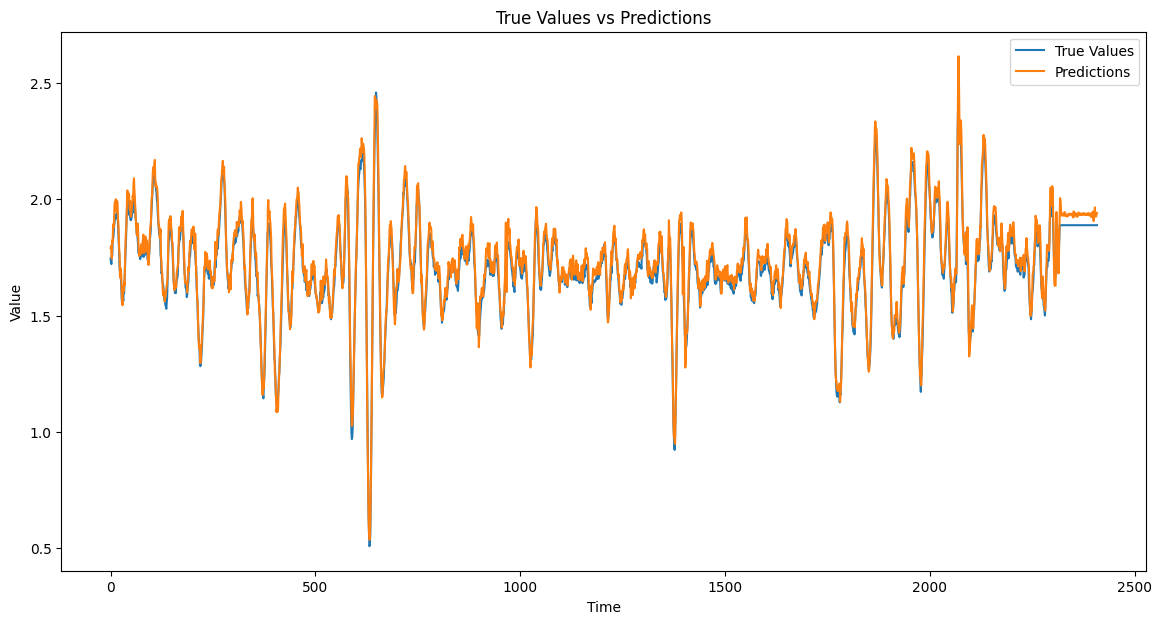

In [40]:
import matplotlib.pyplot as plt

# Assuming predictions and y_test are inverse transformed already
# If not, inverse transform them
y_test_inverse = scaler.inverse_transform(y_test)

# Select a feature to plot (e.g., the first feature)
feature_index = 0

# Plot the true values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse[:, feature_index], label='True Values')
# Plot the predicted values
plt.plot(predictions_inverse[:, feature_index], label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()
